In [1]:
#Python general libraries
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

#Log readers libraries 
import LatLon23
import welly
import lasio

# Machine learning libraries
import xgboost as xg 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score
import sklearn

# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

### Read datafile or create dataframe with log data or use any other file for training data

In [2]:
def read_and_create_table(well):
    well = file
    example1 = lasio.read(well)
    example_df = example1.df()
    
    #create unit_name label
    dtsm_non_nan = example_df.loc[~example_df['DTSM'].isnull(),]

    return dtsm_non_nan

In [3]:
## Check if file is here
if 'ml_data_set.csv' in os.listdir():
    final_dummy_df_final = pd.read_csv('ml_data_set.csv')
    final_dummy_df_final = final_dummy_df_final.set_index('DEPT')
    
else:
    df_list = []
    os.chdir('/Users/restream/SPE competition/ML Challenge Data')
    for file in os.listdir():
        dtsm_non_nan = read_and_create_table(file)
        df_list.append(dtsm_non_nan) 

    final_dummy_df_final = pd.concat(df_list, axis=0)
    final_dummy_df_final = final_dummy_df_final.set_index('DEPT')
    os.chdir('/Users/restream/SPE competition/')
    
final_dummy_df_final

,DTCO,DTSM,GRS,TEND,GRD,NPHI_LS,DPO_LS,LCALD,DRH,RHOB,...,HCAL2R,SPHI_SS,AE20,HCGRS,DPHZLS,NPORLS,SPHILS,APLCLS,HCGRR,HSGRR
DEPT,,,,,,,,,,,,,,,,,,,,,
5490.0,67.4753,112.6439,107.0924,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5490.5,67.7548,113.4218,91.3463,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5491.0,68.6355,115.1048,75.6001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5491.5,67.1643,116.6885,69.7771,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5492.0,69.6354,118.2721,75.1059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17866.0,93.8140,199.8512,NaN,5973.4951,NaN,NaN,0.0918,6.3121,0.0051,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.8156,122.8837
17866.5,95.0072,197.0948,NaN,5963.0542,NaN,NaN,0.0909,6.3189,0.0055,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.7547,123.6070
17867.0,95.6867,192.6882,NaN,5928.0713,NaN,NaN,0.0908,6.3278,0.0066,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.3658,124.2466


### Preprocessing data

### Preserve features with more NaN values or take away features 

In [5]:
test_df = final_dummy_df_final.dropna(thresh=21)
test_df

,DTCO,DTSM,GRS,TEND,GRD,NPHI_LS,DPO_LS,LCALD,DRH,RHOB,...,HCAL2R,SPHI_SS,AE20,HCGRS,DPHZLS,NPORLS,SPHILS,APLCLS,HCGRR,HSGRR
DEPT,,,,,,,,,,,,,,,,,,,,,
10165.0,54.0602,98.5216,34.5052,4175.7619,36.0960,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10165.5,53.5342,98.4007,30.5719,4174.6434,31.9693,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10166.0,53.0081,98.4184,28.0872,4173.5249,28.9206,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10166.5,52.8879,98.4361,26.4942,4166.0822,29.6122,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10167.0,53.0382,98.4538,24.5576,4133.3428,30.5338,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16328.0,85.2306,151.3559,65.7508,4536.5630,NaN,NaN,0.1016,6.5233,0.0019,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.4795,44.3470
16328.5,86.9772,158.7271,70.6552,4537.5913,NaN,NaN,0.0848,6.5268,0.0019,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.5923,50.7729
16329.0,88.7935,165.9605,74.2360,4538.1299,NaN,NaN,0.0815,6.5375,0.0021,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.6193,59.3790


In [6]:
final_dummy_df_final = test_df

#Define training features 
training_list =  list(final_dummy_df_final.columns)
#define target
training_list.remove('DTSM')


### Define training and test data from dataframe

In [7]:
X = final_dummy_df_final[training_list]
y = final_dummy_df_final['DTSM']

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7,random_state=42)

### Hyperparameter tunning with current dataset

In [8]:
def objective(space):
    clf=xg.XGBRegressor(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation,
            early_stopping_rounds=10,verbose=False)
    
    pred = clf.predict(X_test)
    accuracy = np.sqrt(MSE(y_test, pred))
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [9]:
estimator = 450
n_estimators = estimator
seed = 123

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
    }

space['n_estimators']= n_estimators
space['seed']= seed


trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 10,
                        trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams)

SCORE:                                                
10.89989977725536                                     
SCORE:                                                                          
10.892765599829058                                                              
SCORE:                                                                          
10.987857214340563                                                              
SCORE:                                                                           
10.550537604520773                                                               
SCORE:                                                                           
10.919904597721166                                                               
SCORE:                                                                           
11.05918200141006                                                                
SCORE:                                                                    

### Train and test crossvalidation with best hyperparameters

In [10]:
def cross_val_eval(train_test_df, train_cols=None, test_col='DTSM', num_splits=None,space = None):
    """Expects:
        df -> Dataframe with 
        train_cols -> List of column names that you wish to train on
        test_col -> The column that you would like to use as a label (and predict)
        num_split s -> The number of splits to use for cross validation. Test on one, train on the rest.
    
        Returns a modified dataframe with two additional columns:
        pred -> The predicted values from the XGBRegressor
        test_split_train_index -> The exact split that each row was tested on, all other rows were used to train.
    """    
    
    print(train_cols)
    
    X, y = train_test_df[train_cols], train_test_df[[test_col]]
    
    xgb_r = xg.XGBRegressor(objective ='reg:squarederror',  n_estimators =space['n_estimators'], seed = space['seed'],
                            max_depth = int(space['max_depth']), gamma = space['gamma'],reg_alpha = int(space['reg_alpha']),
                            min_child_weight=int(space['min_child_weight']), colsample_bytree=int(space['colsample_bytree']))
    
    kf = sklearn.model_selection.KFold(n_splits=num_splits, shuffle=False, random_state=None)
    kf.get_n_splits(X)
    rmses = []
    predictions = []
    train_test_df['pred'] = -1
    train_test_df['test_split_train_index'] = ''
    split_count = 0
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        xgb_r.fit(X_train, y_train) 
        preds = xgb_r.predict(X_test) 
        train_test_df['pred'].iloc[test_index] = preds
        train_test_df['test_split_train_index'].iloc[test_index] = '%s:%s' % (test_index[0], test_index[-1])
        
        rmse = np.sqrt(MSE(y_test, preds))
        rmses.append(rmse)
        
    print("RMSEs on %s splits: %s." % (num_splits, rmses))
    print("Average RMSE on %s splits: %s." % (num_splits, sum(rmses)/len(rmses)))
    return train_test_df,xgb_r




In [11]:
#Define number of splits
n_splits = 200

#Define best hyperparameters space for cross validation
space_best=best_hyperparams
space_best['n_estimators'] = n_estimators
space_best['seed'] = seed

#Define training (test column is already predefined as default)
training_list =  list(final_dummy_df_final.columns)
training_list.remove('DTSM')

#Run function to cross val with best hyperparameters
xg_pred_df,xgb_r = cross_val_eval(final_dummy_df_final,training_list,num_splits =n_splits, space=space_best)


['DTCO', 'GRS', 'TEND', 'GRD', 'NPHI_LS', 'DPO_LS', 'LCALD', 'DRH', 'RHOB', 'AT20', 'AT60', 'TENR', 'AT10', 'AT30', 'AT90', 'SPR', 'SPHI_LS', 'CALS', 'HSGRS', 'GR', 'DPHI_LS', 'CALD', 'DRHO', 'GRR', 'ILD', 'CILD', 'ILM', 'SFLU', 'DT', 'IDBC', 'IDPH', 'IMBC', 'IMPH', 'LLD', 'LLS', 'PEF', 'RILD', 'SFLA', 'TENS', 'NPHI', 'DPHI', 'DTST', 'CALR', 'MSFL', 'HSGRD', 'TNPH_LS', 'HCALD', 'PEFZ', 'HDRA', 'DPHZ_LS', 'RHOZ', 'RXOZ', 'RLA4', 'RLA5', 'HSGR', 'TNPH_LIM', 'CGRS', 'DTCO_1', 'HCALS', 'HLLD', 'HLLS', 'PR', 'SGRS', 'VPVS', 'SGRDD', 'AST10', 'AST30', 'AST90', 'HCAL', 'DPHZ', 'AFCO', 'AF20', 'AF60', 'GRN', 'HCALR', 'TNPH_LS_1', 'DTL', 'DTLF', 'DTLN', 'RLA3', 'TNPH', 'GR_EDTC', 'SGR', 'HCGR', 'HCGRD', 'RXO8', 'AHT10', 'AHT30', 'AHT90', 'LCAL', 'RHOM', 'DPO', 'PEFL', 'AFCO60', 'DPHZ_SS', 'SGRR', 'TNPH_SS', 'CIDP', 'DT1', 'DT4P', 'DT4PR', 'DT4PT', 'DT4S', 'DT4SR', 'DT4ST', 'SNP', 'CNPOR_LS', 'ECGRS', 'RLA2', 'SPHI', 'TBIT20', 'TBIT30', 'TBIT60', 'TBIT90', 'DT1R', 'DT1T', 'DT2R', 'DTRP', 'DTRS',

/Users/restream/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/restream/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/restream/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

RMSEs on 200 splits: [6.3311968129489085, 11.985751515376712, 16.550823098395487, 13.078574736671738, 11.337698568499205, 21.37555829679062, 18.92492613375026, 6.7545512149729445, 7.384587264642512, 8.407468669899139, 6.2585606142846455, 6.856038301209799, 4.925192924103795, 5.737809385309035, 5.109695066737967, 4.7137130283947375, 6.183537921761197, 3.876875821887656, 3.0308404900572326, 4.738885064990954, 11.901680388298242, 11.474643818499636, 5.81740242991082, 5.938744372731298, 7.643618400208788, 5.581985679767487, 10.359305977851113, 4.6548307274676315, 3.933650062510363, 2.850683071400016, 3.0556971359486016, 3.020624263838955, 3.113191722057038, 3.0404391292042066, 9.703026549403386, 9.06811199720595, 8.571124510924557, 6.847725701817181, 3.6955153130340195, 6.266911249299555, 6.44531328960734, 5.115871721403809, 6.842054163325152, 4.411585359192741, 7.075437862647472, 6.246460141238743, 6.874357862005743, 10.792762737148339, 11.66786711343849, 5.505865374367066, 4.114713669078

/Users/restream/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/restream/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/restream/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Plot results

/Users/restream/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


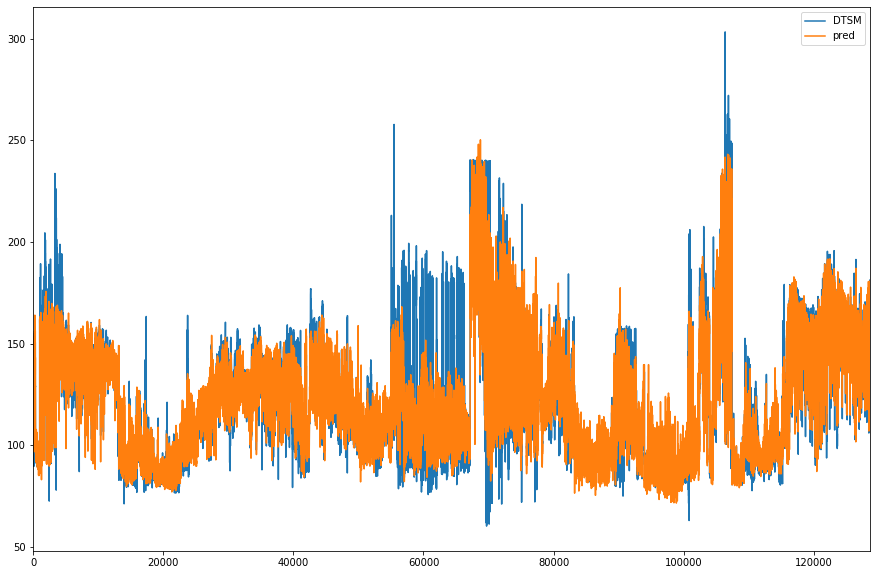

In [12]:
ax = xg_pred_df.reset_index()[['DTSM','pred']].plot(figsize=(15,10))
plt.legend()
plt.show()


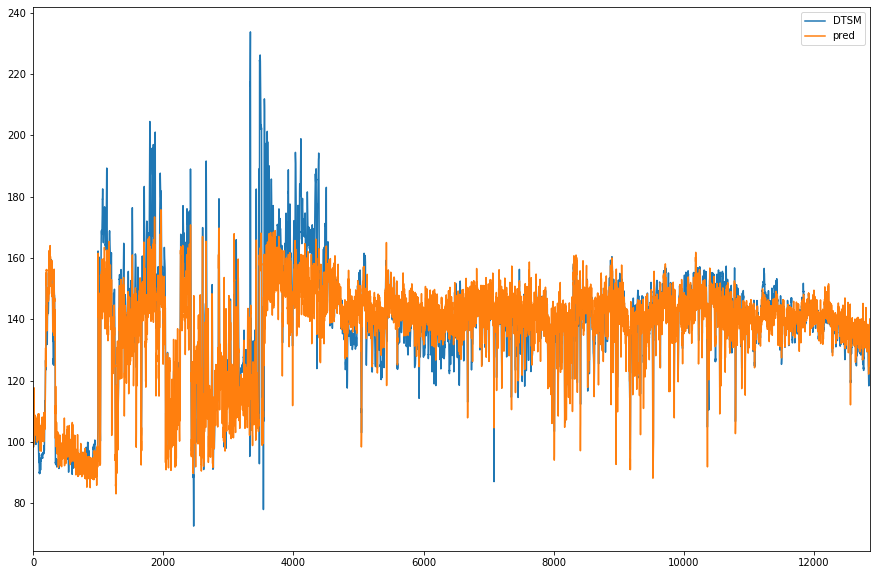

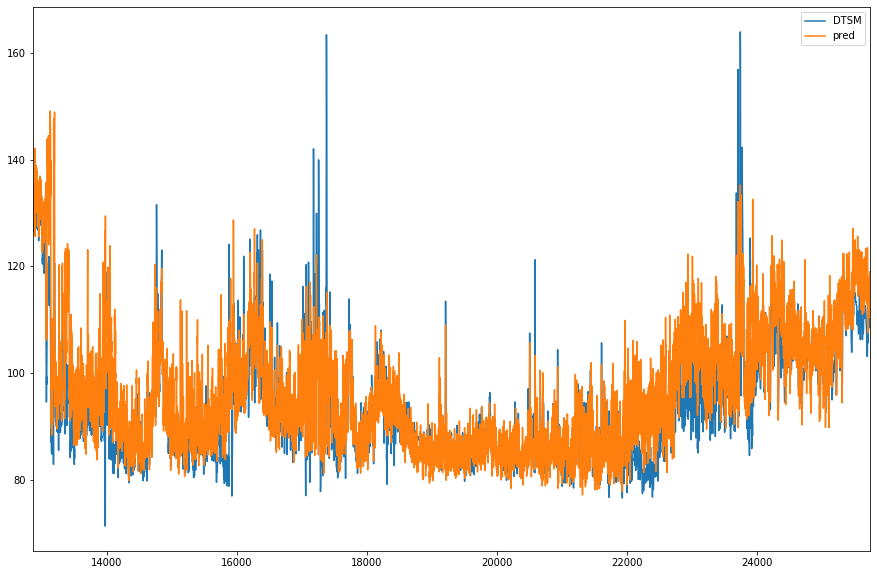

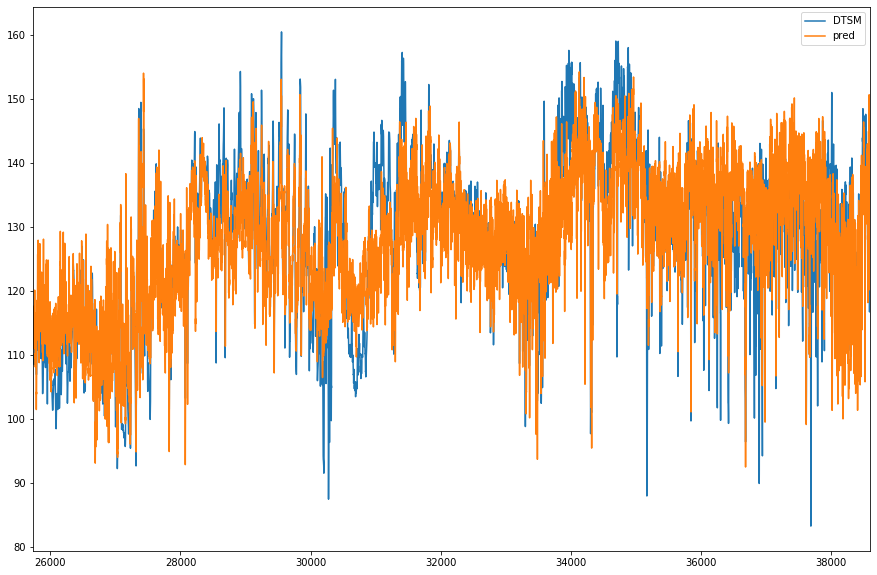

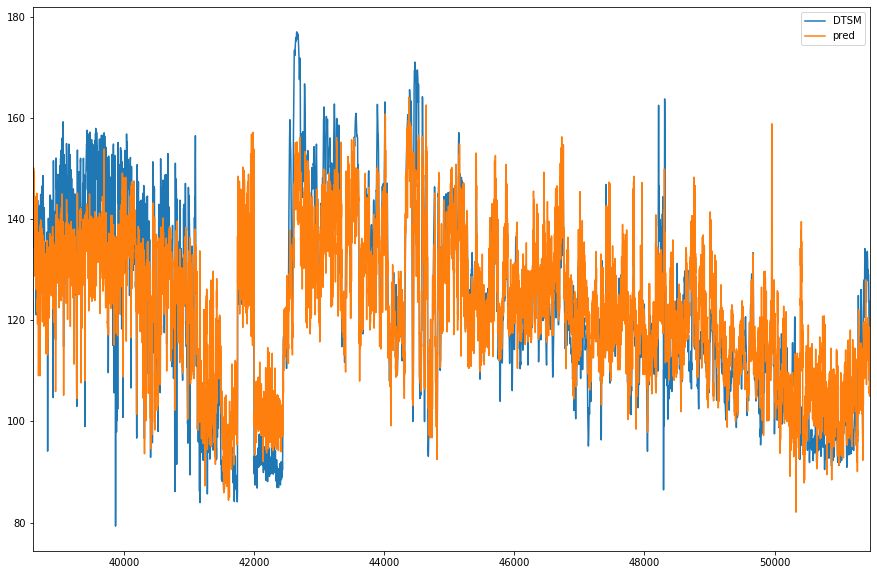

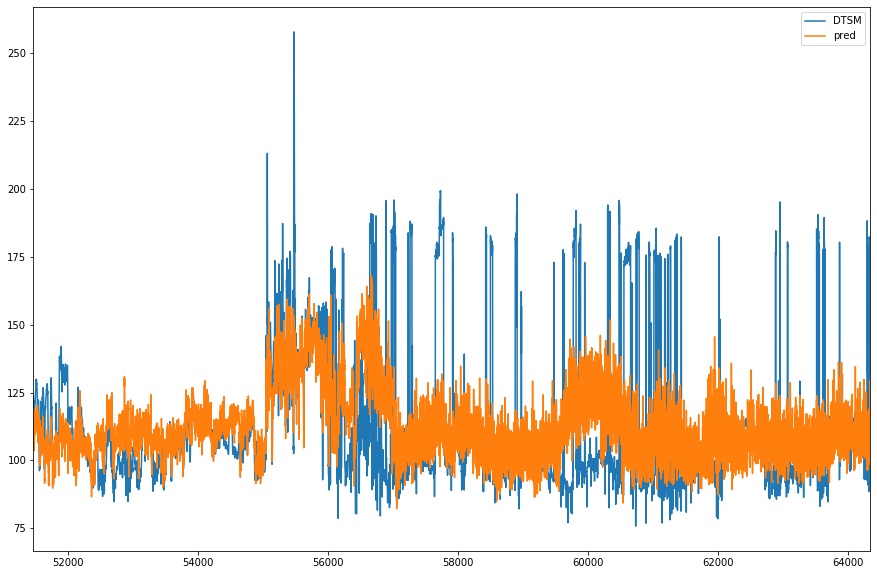

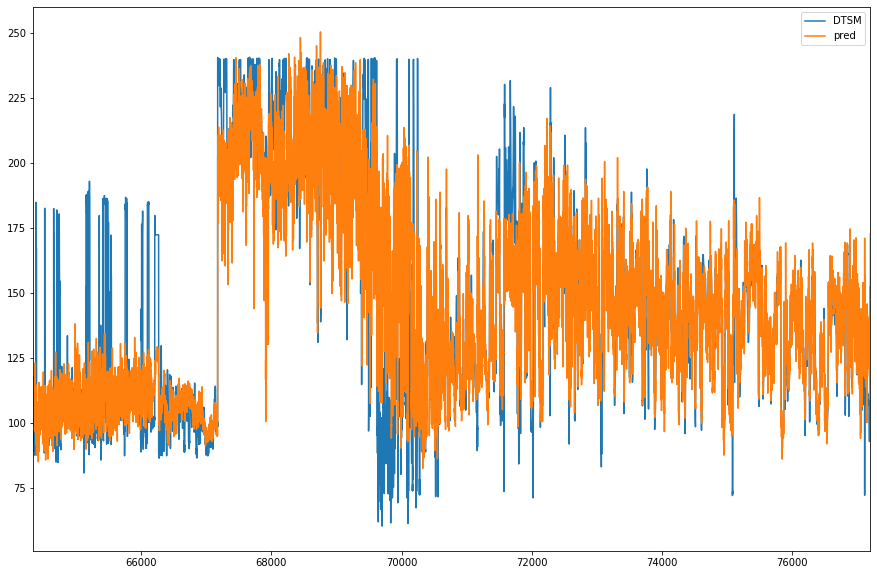

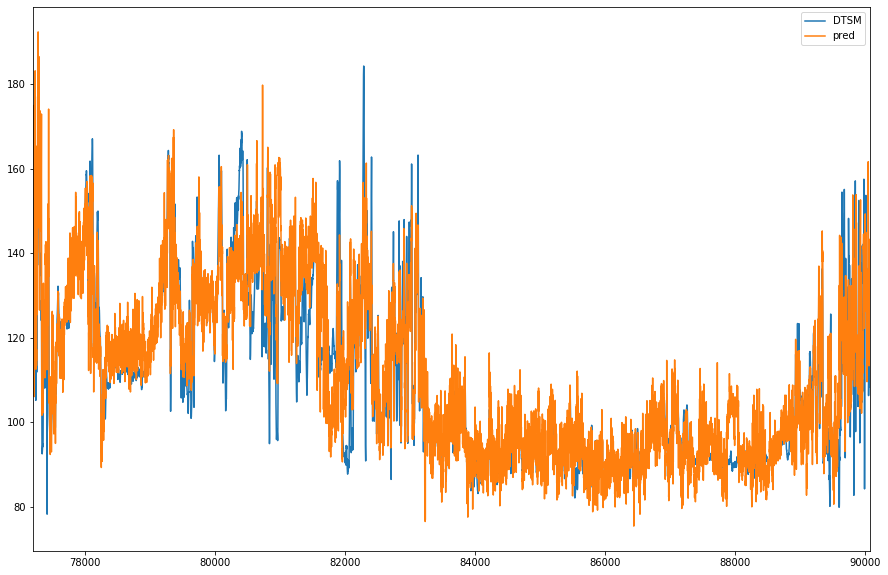

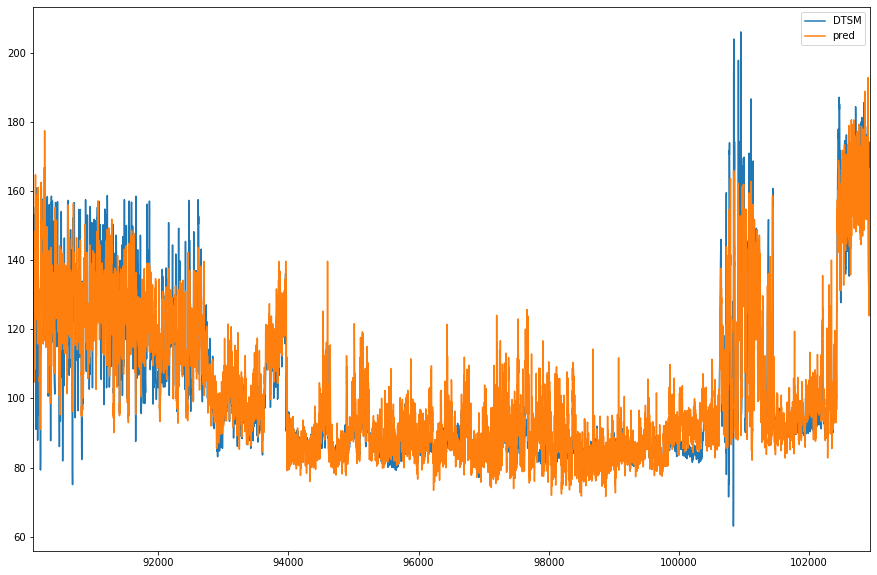

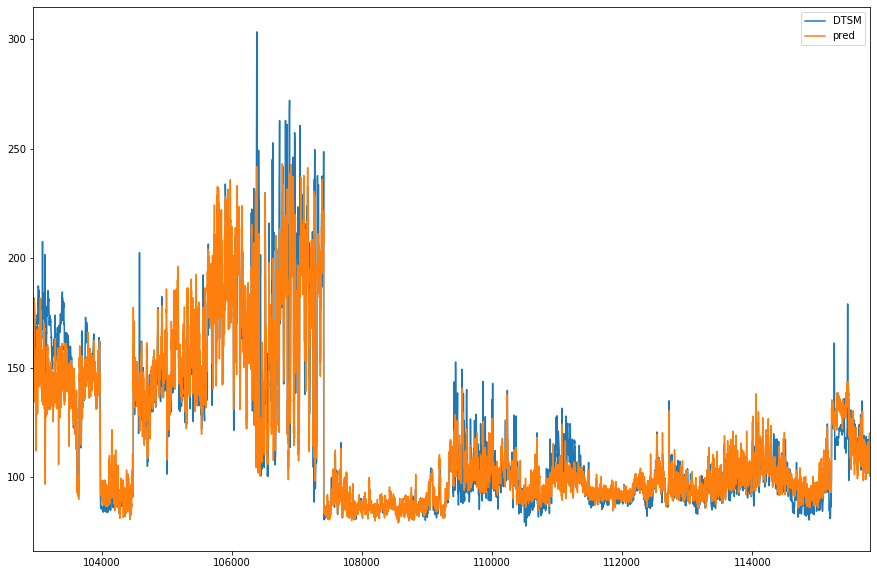

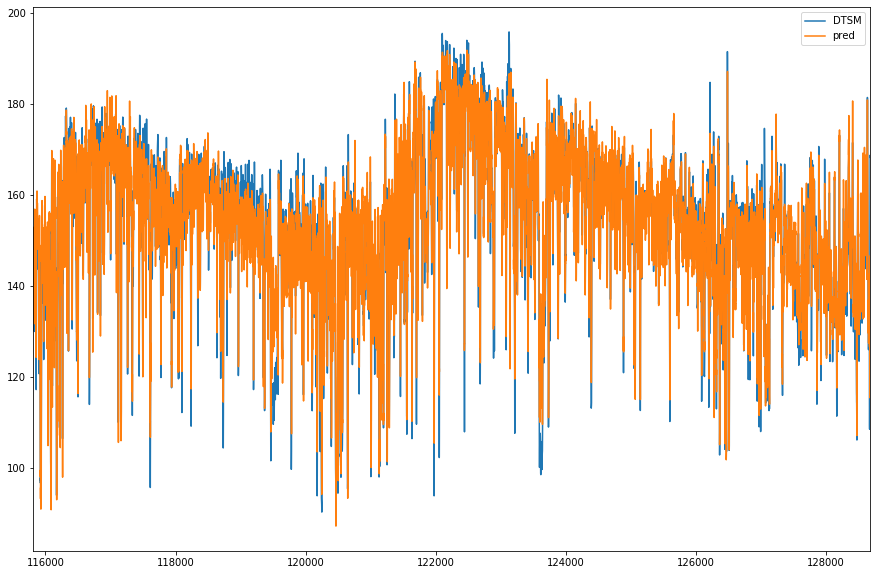

In [13]:
for df in np.array_split(xg_pred_df.reset_index(),10):
    ax = df[['DTSM','pred']].plot(figsize=(15,10))
    plt.legend()
    plt.show()

### Prepare data for testing

In [14]:
training_list =  list(final_dummy_df_final.columns)
training_list.remove('pred')
training_list.remove('test_split_train_index')
training_list.remove('DTSM')


In [15]:
X_train = final_dummy_df_final[training_list]
Y_train = final_dummy_df_final['DTSM']
xgb_r_test = xgb_r

In [16]:
def prediction_function(X_train,X_test,xgb_r_test):
    df = pd.DataFrame()
    for c in X_train.columns:
        if c in X_test.columns:
            df[c] = X_test[c]
        else:
            df[c] = np.nan
    
    preds = xgb_r.predict(df) 

    X_test['DTSM'] = preds
    
    return X_test

### Prediction of test wells

In [17]:
os.chdir('/Users/restream/SPE competition/test data')

for file in os.listdir():
    if file == '.ipynb_checkpoints':
        continue
        
    print(file)
    
    well = lasio.read(file)
    X_test = well.df()
    
    X_test_pred = prediction_function(X_train,X_test,xgb_r_test)
    
    os.chdir('/Users/restream/SPE competition/outputs')
    X_test['DTSM'].to_excel(file.split('.')[0]+'less_data'+'.xlsx',sheet_name=file)
    os.chdir('/Users/restream/SPE competition/test data')
        
os.chdir('/Users/restream/SPE competition/')

Well 5.las
Well 10.las
00d02be79f49_TGS.las
Well 4.las
Well 6.las
638f2cc65681_TGS.las
ff7845ea074d_TGS.las
34a80ab7a5fa_TGS.las
Well 7.las
Well 3.las
eed1e9537976_TGS.las
94c1f5cae85c_TGS.las
Well 2.las
Well 1.las
7595ba9fb314_TGS.las
fca03aa6acde_TGS.las
113412eec2a6_TGS.las
63250f7d463b_TGS.las
2f96a5f92418_TGS.las
302460e3021a_TGS.las
ae16a9f64878_TGS.las
3369b6f8fb6f_TGS.las
8e37531ba266_TGS.las
ed48bda2217f_TGS.las
0a7822c59487_TGS.las
1684cc35f399_TGS.las
84c5fb9cc880_TGS.las
Well 9.las
20372701d5e2_TGS.las
Well 8.las
